In [2]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
import scipy
from scipy import stats
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from base.base_model import BaseModel
from utils import utils
from shash.shash_torch import Shash
# import databuilder.nino_indices as nino_indices # CAUSES CELL TO HANG

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
numpy version = 1.26.4
xarray version = 2024.5.0
pytorch version = 2.0.0.post104


### Extract PRECT anomalies time series over Seattle Metro Area (TARGET)

In [3]:
config = utils.get_config("exp006")
seed = config["seed_list"][0]

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
imp.reload(utils)
imp.reload(filemethods)
imp.reload(data_generator)
imp.reload(data_loader)

data = ClimateData(
    config["databuilder"], 
    expname = config["expname"],
    seed=seed,
    data_dir = config["perlmutter_data_dir"], 
    figure_dir=config["perlmutter_output_dir"],
    target_only = True, 
    fetch=False,
    verbose=False
)

In [4]:
# d_train, d_val, d_test = data.fetch_data()

In [5]:
# d_train["y"][500:540]

In [6]:
# import pickle
# import gzip

# target_PRECT_savename1 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_train_PRECT_1850-2014_unlagged.pkl"
# # target_PRECT_savename1 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_train_SeattleRegional_PRECT_1850-2014_unlagged.pkl"
# with gzip.open(target_PRECT_savename1, "wb") as fp:
#     pickle.dump(d_train, fp)

# target_PRECT_savename2 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_val_PRECT_1850-2014_unlagged.pkl"
# # target_PRECT_savename2 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_val_SeattleRegional_PRECT_1850-2014_unlagged.pkl"
# with gzip.open(target_PRECT_savename2, "wb") as fp:
#     pickle.dump(d_val, fp)

# target_PRECT_savename3 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_test_PRECT_1850-2014_unlagged.pkl"
# # target_PRECT_savename3 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_test_SeattleRegional_PRECT_1850-2014_unlagged.pkl"
# with gzip.open(target_PRECT_savename3, "wb") as fp:
#     pickle.dump(d_test, fp)

Process + Pickle Inputs and Targets

In [7]:
# s_dict_train, s_dict_val, s_dict_test = multi_input_data_organizer(config, MJO = True, ENSO = True, other = False)

In [8]:
# s_dict_train["y"][500:540]

In [9]:
s_dict_savename1 = str(config["perlmutter_data_dir"]) + 'presaved/exp006_train_unlagged_28.pkl'
# s_dict_savename1 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_train_unlagged.pkl'
# with gzip.open(s_dict_savename1, "wb") as fp:
#     pickle.dump(s_dict_train, fp)

s_dict_savename2 = str(config["perlmutter_data_dir"]) + 'presaved/exp006_val_unlagged_28.pkl'
# s_dict_savename2 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_val_unlagged.pkl'
# with gzip.open(s_dict_savename2, "wb") as fp:
#     pickle.dump(s_dict_val, fp)

s_dict_savename3 = str(config["perlmutter_data_dir"]) + 'presaved/exp006_test_unlagged_28.pkl'
# s_dict_savename3 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test_unlagged.pkl'
# with gzip.open(s_dict_savename3, "wb") as fp:
#     pickle.dump(s_dict_test, fp)

with gzip.open(s_dict_savename1, "rb") as obj1:
    train_dat = pickle.load(obj1)
obj1.close()

with gzip.open(s_dict_savename2, "rb") as obj2:
    val_dat = pickle.load(obj2)
obj2.close()

with gzip.open(s_dict_savename3, "rb") as obj3:
    test_dat = pickle.load(obj3)
obj3.close()

In [10]:
test_dat["y"][500:530]

array([-0.31508507, -0.59007876, -0.70724232, -0.87925047, -1.1763967 ,
       -1.40074942, -1.37202487, -0.3989221 ,  0.50132237,  0.732156  ,
        0.94909161,  0.93705243,  0.93764725,  0.69884537,  0.49327993,
        0.53023835,  0.76036884,  0.82201122,  0.61755086,  0.32327671,
        0.36869985, -0.51247113, -1.04501366, -1.02951334, -1.27004938,
       -1.33892359, -1.45747402, -0.89937213,  0.28071263,  0.66966961])

In [11]:
# print(np.isnan(train_dat["x"][121:-32]).any())
# print(np.isnan(val_dat["x"][121:-32]).any())
# print(np.isnan(test_dat["x"][121:-32]).any())

# print(np.isnan(train_dat["y"][121:-32]).any())
# print(np.isnan(val_dat["y"][121:-32]).any())
# print(np.isnan(test_dat["y"][121:-32]).any())

Retrieve Data: 


In [9]:
# Setup the Data
lagtime = config["databuilder"]["lagtime"] 
smoothing_length = config["databuilder"]["averaging_length"]

trainset = data_loader.CustomData(config["data_loader"]["perlmutter_data_dir"] + "exp006_train_unlagged_28.pkl", config)
valset = data_loader.CustomData(config["data_loader"]["perlmutter_data_dir"] + "exp006_val_unlagged_28.pkl", config)
testset = data_loader.CustomData(config["data_loader"]["perlmutter_data_dir"] + "exp006_test_unlagged_28.pkl", config)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_train_unlagged_28.pkl
<class 'numpy.ndarray'>
X shape: (60037, 3)
Target shape: (60037,)
Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_val_unlagged_28.pkl
<class 'numpy.ndarray'>
X shape: (60037, 3)
Target shape: (60037,)
Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_test_unlagged_28.pkl
<class 'numpy.ndarray'>
X shape: (60037, 3)
Target shape: (60037,)


Model Setup

In [13]:
# Setup the Model
model = TorchModel(
    config=config["arch"],
    target_mean=trainset.target.mean(axis=0),
    target_std=trainset.target.std(axis=0),
)
std_mean = {"trainset_target_mean": trainset.target.mean(axis=0), "trainset_target_std": trainset.target.std(axis=0)}

model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

somwhere device = cpu


In [14]:
# # # Visualize the model
# torchinfo.summary(
#     model,
#     [   trainset.input[: config["data_loader"]["batch_size"]].shape ],
#     verbose=1,
#     col_names=("input_size", "output_size", "num_params"),
# )

# Train the Model
model.to(device)
trainer.fit()

/pscratch/sd/p/plutzner/E3SM/databuilder/data_loader.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [ torch.tensor(input, dtype=torch.float32)],
/pscratch/sd/p/plutzner/E3SM/model/metric.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(output)
/pscratch/sd/p/plutzner/E3SM/model/metric.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Epoch   0/2000
  5.1s - loss: 2.19449 - val_loss: 2.20961
Epoch   1/2000
  4.2s - loss: 2.19290 - val_loss: 2.20846
Epoch   2/2000
  3.2s - loss: 2.19215 - val_loss: 2.20739
Epoch   3/2000
  3.2s - loss: 2.19081 - val_loss: 2.20638
Epoch   4/2000
  3.2s - loss: 2.19016 - val_loss: 2.20542
Epoch   5/2000
  3.2s - loss: 2.18913 - val_loss: 2.20450
Epoch   6/2000
  3.2s - loss: 2.18895 - val_loss: 2.20362
Epoch   7/2000
  3.2s - loss: 2.18814 - val_loss: 2.20277
Epoch   8/2000
  3.2s - loss: 2.18750 - val_loss: 2.20197
Epoch   9/2000
  3.2s - loss: 2.18657 - val_loss: 2.20120
Epoch  10/2000
  3.2s - loss: 2.18599 - val_loss: 2.20045
Epoch  11/2000
  3.2s - loss: 2.18548 - val_loss: 2.19973
Epoch  12/2000
  3.2s - loss: 2.18527 - val_loss: 2.19904
Epoch  13/2000
  3.2s - loss: 2.18390 - val_loss: 2.19836
Epoch  14/2000
  3.2s - loss: 2.18336 - val_loss: 2.19771
Epoch  15/2000
  3.2s - loss: 2.18315 - val_loss: 2.19708
Epoch  16/2000
  3.2s - loss: 2.18313 - val_loss: 2.19648
Epoch  17/2000

In [15]:
# Save the Model
# path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_RERUN_Nov2024.pth'
path = str(config["perlmutter_model_dir"]) + 'exp006_RERUN.pth'
torch.save({
            "model_state_dict" : model.state_dict(),
            "training_std_mean" : std_mean,
             }, path)
# torch.save(model.state_dict(), path)

In [16]:
# Load the Model
# path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_RERUN_Nov2024.pth'
path = str(config["perlmutter_model_dir"]) + 'exp006_RERUN.pth'

load_model_dict = torch.load(path)

state_dict = load_model_dict["model_state_dict"]
training_std_mean = load_model_dict["training_std_mean"]

model = TorchModel(
    config=config["arch"],
    target_mean=training_std_mean["trainset_target_mean"],
    target_std=training_std_mean["trainset_target_std"],
)

model.load_state_dict(state_dict)
model.eval()

TorchModel(
  (layer1): Linear(in_features=3, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=6, bias=True)
  (final): Linear(in_features=6, out_features=4, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (output_mu): Linear(in_features=6, out_features=1, bias=True)
  (output_sigma): Linear(in_features=6, out_features=1, bias=True)
  (output_gamma): Linear(in_features=6, out_features=1, bias=True)
  (output_tau): Linear(in_features=6, out_features=1, bias=True)
)

dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


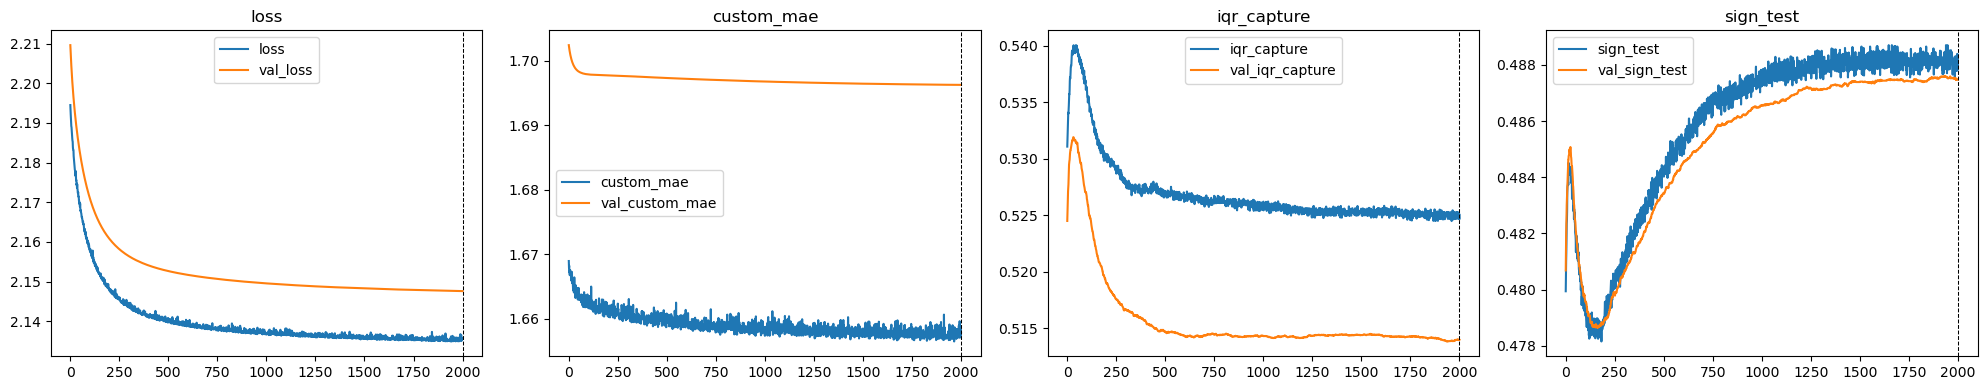

In [18]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
       x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.savefig(config["perlmutter_figure_dir"] + str(config["expname"]) + "/training_metrics_exp006_RERUN.png", format = 'png', dpi = 300) 
plt.show()

Plot Predictions Against Climatology: 

In [19]:
with torch.inference_mode():
    print(device)
    output = model.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters
output[:20]

cpu


array([[-1.1354105 ,  1.8650148 ,  0.45437223,  1.        ],
       [-1.135042  ,  1.8598331 ,  0.45459354,  1.        ],
       [-1.1323396 ,  1.8605314 ,  0.45374548,  1.        ],
       [-1.1301081 ,  1.8618304 ,  0.45298478,  1.        ],
       [-1.1285022 ,  1.8653048 ,  0.45224148,  1.        ],
       [-1.128552  ,  1.8689975 ,  0.45194185,  1.        ],
       [-1.1264186 ,  1.8650041 ,  0.45158792,  1.        ],
       [-1.1198754 ,  1.8516164 ,  0.45068926,  1.        ],
       [-1.1143104 ,  1.8483678 ,  0.4486413 ,  1.        ],
       [-1.127316  ,  1.8557193 ,  0.4474273 ,  1.        ],
       [-1.1501921 ,  1.8816335 ,  0.44424042,  1.        ],
       [-1.2112762 ,  1.9363692 ,  0.4364323 ,  1.        ],
       [-1.2497174 ,  1.9781634 ,  0.43117625,  1.        ],
       [-1.2614326 ,  2.0099359 ,  0.42851946,  1.        ],
       [-1.3150674 ,  2.0189598 ,  0.41670915,  1.        ],
       [-1.3118043 ,  1.9918532 ,  0.4128324 ,  1.        ],
       [-1.3110954 ,  1.

In [20]:
# Save Model Outputs
model_output_pred = str(config["perlmutter_output_dir"]) + 'exp006_output_pred_testset_RERUN.pkl'
with gzip.open(model_output_pred, "wb") as fp:
    pickle.dump(output, fp)

In [8]:
# Open Model Outputs
model_output_pred = str(config["perlmutter_output_dir"]) + 'exp006_output_pred_testset_RERUN.pkl'
with gzip.open(model_output_pred, "rb") as obj1:
    output = pickle.load(obj1)

Opened pickle file: /pscratch/sd/p/plutzner/E3SM/saved/output/exp006_output_pred_testset.pkl
Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_test_unlagged_28.pkl
Climatologial Mean = -0.0003209149518019387


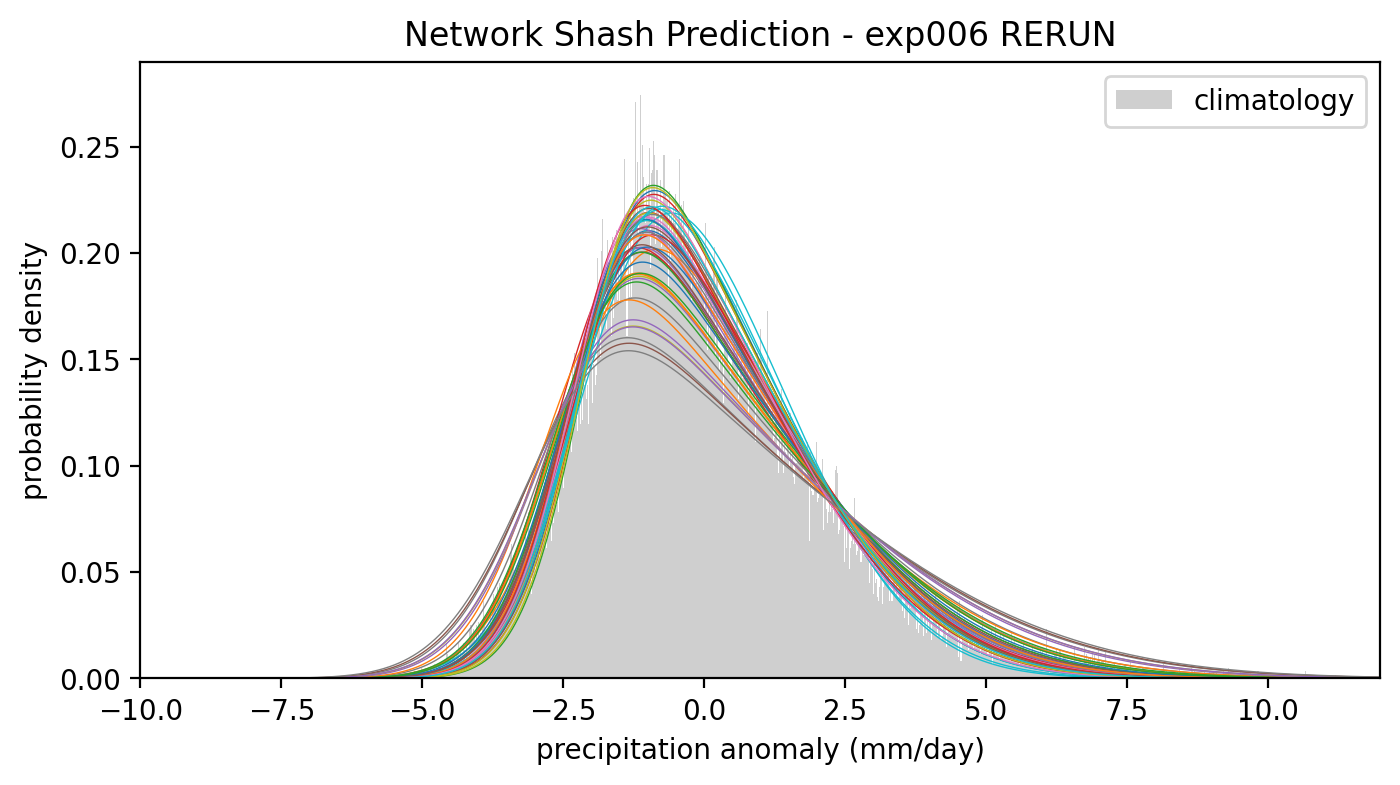

In [11]:
import analysis.calc_climatology as calc_climatology
from analysis import analysis_metrics

exp006_original_output = filemethods.open_data_file('/pscratch/sd/p/plutzner/E3SM/saved/output/exp006_output_pred_testset.pkl')

lagtime = config["databuilder"]["lagtime"] 
smoothing_length = config["databuilder"]["averaging_length"]  

# Open Target Data
# target = xr.open_dataset('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/' + str(config["expname"]) + '_d_test_1850-1900.nc')
target = filemethods.open_data_file(config["perlmutter_data_dir"] + 'presaved/exp006_test_unlagged_28.pkl')
target = target["y"][lagtime:]
target = target[smoothing_length:]

# Open Climatology Data: TRAINING DATA
# climatology_filename = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/' + str(config["expname"]) + '_d_train_1850-1900.nc'
climatology_filename = str(config["perlmutter_data_dir"]) + 'presaved/exp006_train_unlagged_28.pkl'
climatology_da = analysis_metrics.load_pickle(climatology_filename)
climatology = climatology_da["y"][lagtime:]
climatology = climatology[smoothing_length:]

# Compare SHASH predictions to climatology histogram
x = np.arange(-10, 12, 0.01)

# p = calc_climatology.deriveclimatology(exp006_original_output, climatology, x, number_of_samples=50, config=config, climate_data = climatology_filename)

p = calc_climatology.deriveclimatology(output, climatology, x, number_of_samples=50, config=config, climate_data = climatology_filename)

## CRPS - Compare Distributions against Target / Climatology  ------------------------------

#### Proper Scoring CRPS Calculations: 
https://github.com/properscoring/properscoring/blob/master/properscoring/_crps.py

In [ ]:
with gzip.open('/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_CRPS_testset_allsamples_V2.pkl', "rb") as obj1:
    crps_scores = pickle.load(obj1)

print(f" The Mean CRPS score is: {np.round(crps_scores.mean(), 4)}")
print(crps_scores.shape)

### Climatology as Distribution

In [ ]:
with gzip.open('/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_CRPS_climatology_testset_allsamples_V2.pkl', "rb") as obj1:
    crps_climatology_scores = pickle.load(obj1)

print(crps_climatology_scores.shape)

print(f" The Mean Climatology CRPS score is: {np.round(crps_climatology_scores.mean(), 4)}")
print(f"Median Climatology CRPS score is: {np.round(np.median(crps_climatology_scores), 4)}")
climatology_median = np.median(crps_climatology_scores)

In [ ]:
 # Calculate the mean CRPS scores for the forecast and climatology
CRPS_forecast = np.round(np.mean(crps_scores), 4)
CRPS_climatology = np.round(np.mean(crps_climatology_scores), 4)

# Plot CRPS comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(np.arange(0, len(crps_scores)), crps_scores, alpha = 0.4, s=0.4, color ='#26828e', label = f'Forecast CRPS Average: {CRPS_forecast} ')
ax.scatter(np.arange(0, len(crps_climatology_scores)), crps_climatology_scores,  alpha = 0.4, s=0.4, color ='#f5a962', label = f'Climatology CRPS Average: {CRPS_climatology} ')
ax.set_title("CRPS Comparison")
ax.set_xlabel("Sample Index")
ax.set_ylabel("CRPS Score")
ax.legend(markerscale = 9)
plt.savefig('/Users/C830793391/Documents/Research/E3SM/figures/exp006/CRPS_comparison_exp006_RERUN.png')
plt.show()


### Sort Data into Phases

In [ ]:
from analysis.ENSO_indices_calculator import identify_nino_phases
# Gather ENSO index for *each* sample
#(https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)

# Nino34 = testset.input[:,2] # From loaded network inputs above (testset(RMM1, RMM2, NINO34))

monthlyENSO = xr.open_dataset('/Users/C830793391/BIG_DATA/E3SM_Data/presaved/ENSO_ne30pg2_HighRes/nino.member0201.nc')
Nino34 = monthlyENSO.nino34.values

enso_indices_daily = identify_nino_phases(Nino34, threshold = 0.4, window = 6, front_cutoff = front_cutoff, back_cutoff = back_cutoff)
# Isolate non-zero indices for each ENSO phase
maxnino =  max(np.where(enso_indices_daily[:,0] != 0)[0])
maxneutral = max(np.where(enso_indices_daily[:,2] != 0)[0])
print(maxneutral)
elnino = enso_indices_daily[:17321, 0]
lanina = enso_indices_daily[:17010, 1]
non_neutral = np.concatenate((elnino, lanina))
neutral = np.setdiff1d(np.arange(0, 60225), non_neutral)[:(len(crps_scores) - (len(elnino) + len(lanina)))]

CRPS_elnino = np.round(crps_scores[elnino].mean(), 4)
CRPS_lanina = np.round(crps_scores[lanina].mean(), 4)
CRPS_neutral = np.round(crps_scores[neutral].mean(), 4)

# Plot CRPS by ENSO index
# create a subplot with three columns and one row
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharey=True)
ax[0].scatter(elnino, crps_scores[elnino], s=0.4, color ='#26828e', label = f'CRPS Average: {CRPS_elnino} ')
ax[0].set_title('El Nino')
ax[0].set_ylabel('CRPS')
ax[1].scatter(lanina, crps_scores[lanina], s=0.4, color = '#26828e', label = f'CRPS Average: {CRPS_lanina}')
ax[1].set_title('La Nina')
ax[1].set_ylabel('CRPS')
ax[2].scatter(neutral, crps_scores[neutral], s=0.4, color = '#26828e', label = f'CRPS Average: {CRPS_neutral}')
ax[2].set_title('Neutral')
ax[2].set_xlabel('Time (Samples in Chronological Order)')
ax[2].set_ylabel('CRPS')
ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right') 
ax[2].legend(loc = 'upper right')
plt.subplots_adjust(hspace=0.3)

print(f"El Nino average CRPS across all samples: {np.round(crps_scores[elnino].mean(), 4)}")
print(f"La Nina average CRPS across all samples: {np.round(crps_scores[lanina].mean(), 4)}")
print(f"Neutral average CRPS across all samples: {np.round(crps_scores[neutral].mean(), 4)}")

plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/CRPS_vs_ENSO_Phases_exp006_allsamples.png', format='png', bbox_inches ='tight', dpi = 300)

# Weighted average confirmation: 
CRPS_weightedmean = (CRPS_elnino*elnino.shape[0] + CRPS_lanina*lanina.shape[0] + CRPS_neutral*neutral.shape[0])/(elnino.shape[0] + lanina.shape[0] + neutral.shape[0])
print(f"Weighted average CRPS across all samples: {np.round(CRPS_weightedmean, 4)}")

### Discard Plot : CRPS vs IQR Percentile

In [ ]:
from model.metric import iqr_basic

target = testset.target

print("output type:", type(output))
print("output shape:", output.shape if hasattr(output, 'shape') else "N/A")
print("testset type:", type(target))
print("testset shape:", target.shape if hasattr(target, 'shape') else "N/A")

# iqr capture relies on SHASH output parameters (mu, sigma, tau, gamma) and the SHASH class
iqr = iqr_basic(output)

In [ ]:
plt.figure()
plt.plot(iqr, crps_scores, 'o', markersize=1)
plt.xlabel('Interquartile Range (IQR)')
plt.ylabel('CRPS Score')

In [ ]:
# Generate an array of averaged CRPS score for each bin of IQR percentile (100, 95, 90, 85, etc.)
percentiles = np.linspace(100, 0, 101)

avg_crps = []
avg_target = []
sample_index = np.zeros((len(target), len(percentiles)))
for ip, p in enumerate(percentiles):
    avg_crps.append(np.mean(crps_scores[iqr < np.percentile(iqr, p)]))
    avg_target.append(np.mean(target[iqr < np.percentile(iqr, p)]))
    # capture the index (out of 60058) for all the samples in each bin
    indices = np.where(iqr < np.percentile(iqr, p))[0]
    sample_index[:len(indices), ip] = indices

color = 'tab:blue'
fig, ax1 = plt.subplots()
plt.gca().invert_xaxis()
ax1.set_ylabel('Average CRPS')
ax1.set_xlabel('IQR Percentile (% Data Remaining)', color=color)
ax1.plot(percentiles, avg_crps, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=crps_climatology_scores.mean(), color='grey', linestyle='--', label='Climatology Mean')
ax1.set_ylim([1.05, 1.205])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:olive'
ax2.set_ylabel('Average Target Anomalies (mm/day)', color=color)
ax2.plot(percentiles, avg_target, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/CRPS_IQR_DiscardPlot_fine_mean_V2.png', format='png', bbox_inches ='tight', dpi = 300)

#### Identify actual target anomolous precipitation data : 

In [ ]:
# find all raw precip anaomaly data: 
# extract from netcdf:
nc_file = xr.open_dataset('/Users/C830793391/BIG_DATA/E3SM_Data/ens3/PRECT.v2.LR.historical_0201.eam.h1.1850-2014.nc')
prect_global = nc_file.PRECT

min_lat, max_lat = config["databuilder"]["target_region"][:2]
min_lon, max_lon = config["databuilder"]["target_region"][2:]

if isinstance(prect_global, xr.DataArray):
    mask_lon = (prect_global.lon >= min_lon) & (prect_global.lon <= max_lon)
    mask_lat = (prect_global.lat >= min_lat) & (prect_global.lat <= max_lat)
    prect_regional = prect_global.where(mask_lon & mask_lat, drop=True)

prect_regional = prect_regional.mean(dim=['lat', 'lon']).values[front_cutoff + 7 : - (back_cutoff+8)]
print(f"prect_regional shape: {prect_regional.shape}")

# Convert to mm/day
target_raw = prect_regional * 86400 * 1000

print(np.mean(target_raw))
print(np.median(target_raw))
print(np.std(target_raw))

In [ ]:
# sample indices for IQR: 
def samples_by_IQR(sample_indices, percentile, quantity): 
    narrow_indices = sample_indices[:, 100-percentile]
    # eliminate zero-values from indices:
    narrow_indices = narrow_indices[narrow_indices != 0]
    narrow_indices = narrow_indices.astype(int)

    narrow_values = quantity[narrow_indices]
    return narrow_values, narrow_indices

# Narrowest 15% IQR for Target Anomalies: 
narrow_10P_anoms, index10P_anoms = samples_by_IQR(sample_index, 10, target)
narrow_10P_anoms_med = np.median(narrow_10P_anoms)
narrow_10P_anoms_mean = np.mean(narrow_10P_anoms)
print(f"Median of 10% IQR Target Anomalies: {narrow_10P_anoms_med}")
print(f"Mean of 10% IQR Target Anomalies: {narrow_10P_anoms_mean}")
print(f"Standard Deviation of 10% IQR Target Anomalies: {np.std(narrow_10P_anoms)}\n")

# Narrowest 15% IQR for True Target Values: 
narrow_10P_true, index10P_true = samples_by_IQR(sample_index, 10, target_raw)
narrow_10P_true_med = np.median(narrow_10P_true)
narrow_10P_true_mean = np.mean(narrow_10P_true)
print(f"Median of 10% IQR True Target Values: {narrow_10P_true_med}")
print(f"Mean of 10% IQR True Target Values: {narrow_10P_true_mean}")
print(f"Standard Deviation of 10% IQR True Target Values: {np.std(narrow_10P_true)}\n")

# Most Accruate CRPS - Target Anomalies: 
narrow_20P_anoms, index20P_anoms = samples_by_IQR(sample_index, 20, target)
narrow_20P_anoms_med = np.median(narrow_20P_anoms)
narrow_20P_anoms_mean = np.mean(narrow_20P_anoms)
print(f"Median of 20% IQR Target Anomalies: {narrow_20P_anoms_med}")
print(f"Mean of 20% IQR Target Anomalies: {narrow_20P_anoms_mean}")
print(f"Standard Deviation of 20% IQR Target Anomalies: {np.std(narrow_20P_anoms)}\n")

# Most Accurate CRPS - True Target Values:
narrow_20P_true, index20P_true = samples_by_IQR(sample_index, 20, target_raw)
narrow_20P_true_med = np.median(narrow_20P_true)
narrow_20P_true_mean = np.mean(narrow_20P_true)
print(f"Median of 20% IQR True Target Values: {narrow_20P_true_med}")
print(f"Mean of 20% IQR True Target Values: {narrow_20P_true_mean}")
print(f"Standard Deviation of 20% IQR True Target Values: {np.std(narrow_20P_true)}\n")

# Most Accruate CRPS - Target Anomalies: 
narrow_40P_anoms, index40P_anoms = samples_by_IQR(sample_index, 40, target)
narrow_40P_anoms_med = np.median(narrow_40P_anoms)
narrow_40P_anoms_mean = np.mean(narrow_40P_anoms)
print(f"Median of 40% IQR Target Anomalies: {narrow_40P_anoms_med}")
print(f"Mean of 40% IQR Target Anomalies: {narrow_40P_anoms_mean}")
print(f"Standard Deviation of 40% IQR Target Anomalies: {np.std(narrow_40P_anoms)}\n")

# Most Accurate CRPS - True Target Values:
narrow_40P_true, index40P_true = samples_by_IQR(sample_index, 40, target_raw)

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(target_raw, bins=100, alpha=0.5, label='Raw Precipitation Data (mm/day)', color = '#b5de2b')
plt.hist(narrow_40P_true, bins=100, alpha = 0.4,  label='Narrowest 40% IQR True Target Values (mm/day) (LOWEST CRPS)', color = '#21918c')
plt.hist(narrow_20P_true, bins=100, alpha = 0.4,  label='Narrowest 20% IQR True Target Values (mm/day) (LOWEST CRPS)', color = '#3b528b')
plt.hist(narrow_10P_true, alpha = 0.4, bins=100, label='Narrowest 10% IQR True Target Values (mm/day)', color = 'purple')
plt.xlabel('True Precipitation Amounts (mm/day)')
plt.ylabel('Frequency')
plt.xlim(-0.1, 35)
plt.legend()

plt.figure(figsize=(8, 5))
plt.hist(target_raw, bins=100, alpha=0.5, density = True, label='Raw Precipitation Data (mm/day)', color = '#b5de2b')
plt.hist(narrow_40P_true, bins=100, density = True, alpha = 0.4,  label='Narrowest 40% IQR True Target Values (mm/day) (LOWEST CRPS)', color = '#21918c')
plt.hist(narrow_20P_true, bins=100,density = True,  alpha = 0.4,  label='Narrowest 20% IQR True Target Values (mm/day) (LOWEST CRPS)', color = '#3b528b')
plt.hist(narrow_10P_true, density = True, alpha = 0.4, bins=100, label='Narrowest 10% IQR True Target Values (mm/day)', color = 'purple')
plt.xlabel('True Precipitation Amounts (mm/day)')
plt.ylabel('Frequency')
plt.ylim(0, .2)
# plt.xlim(0, 20)
plt.legend()

In [ ]:
plt.figure(figsize=(8, 4.6))
plt.hist(target, bins=100, alpha=0.5, density = True, label='All Precipitation Anomalies (mm/day)', color = '#b5de2b')
plt.hist(narrow_40P_anoms, bins=100, density = True, alpha=0.4,  label='Narrowest 40% IQR Target Anomalies (mm/day) LOWEST CRPS', color = '#21918c')
plt.axvline(x=narrow_40P_anoms_med, color='#21918c', linewidth = 0.8, linestyle='--', label='Mean Narrowest 40% IQR Target Anomalies')
plt.hist(narrow_20P_anoms, bins=100, density = True, alpha=0.4,  label='Narrowest 20% IQR Target Anomalies (mm/day) LOWEST CRPS', color = '#3b528b')
plt.axvline(x=narrow_20P_anoms_med, color='#3b528b', linewidth = 0.8, linestyle='--', label='Mean Narrowest 20% IQR Target Anomalies')
plt.hist(narrow_10P_anoms, bins=100, density = True, alpha=0.5, label='Narrowest 10% IQR Target Anomalies (mm/day)', color = 'purple')
plt.axvline(x=narrow_10P_anoms_med, color='purple', linewidth = 0.8, linestyle='--', label='Mean Narrowest 10% IQR Target Anomalies')
plt.legend(bbox_to_anchor=(1.18, 1), loc='upper right')
plt.xlabel('Precipitation Anomalies (mm/day)')
plt.ylabel('Normalized Frequency')


In [ ]:
elnino_dots = np.zeros(elnino.shape)
lanina_dots = np.zeros(lanina.shape)

# Scatter Compare: 
plt.figure(figsize=(8, 4))
plt.scatter(sample_index[:,0], target, label = 'All target Anomalies (mm/day)', s=.5, color = '#3b528b')
plt.scatter(index10P_anoms, narrow_10P_anoms, label='Narrowest 10% IQR Target Anomalies (mm/day)', s=.5, color = '#5ec962')
plt.scatter(elnino, elnino_dots, label='El Nino Events', s=.5, color = '#fdca26')
plt.xlabel('Time \n (Daily Samples in Chronological Order)')
plt.ylabel('Precipitation Anomalies (mm/day)')
plt.legend(markerscale = 3.5, loc = 'upper right')
plt.ylim(-7, 22)

plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/narrowest10P_anoms_scatter_compare_ENSO_V2.png', format='png', bbox_inches ='tight', dpi = 300)

print(target[elnino].shape)


# Percent of narrowest IQR Target anomalies that occur during El Nino events:
narrow10_during_elnino = np.intersect1d(index10P_anoms, elnino)
narrow10_during_elnino_percent = (narrow10_during_elnino.shape[0]/index10P_anoms.shape[0])*100
print(f"Percent of narrowest 10% IQR Target Anomalies that occur during El Nino events: {narrow10_during_elnino_percent}%")


In [ ]:
# Scatter Compare: 
plt.figure(figsize=(13, 4))
plt.scatter(sample_index[neutral,0], target[neutral], alpha = 0.8, label = 'Neutral target Anomalies (mm/day)', s=0.1, color = '#b0b0b0')
plt.scatter(sample_index[elnino,0], target[elnino], alpha = 0.8, label = 'El Nino target Anomalies (mm/day)', s=0.1, color = '#648FFF')
plt.scatter(sample_index[lanina,0], target[lanina], alpha = 0.8, label = 'La Nina target Anomalies (mm/day)', s=0.1, color = '#FFB000')
# plt.scatter(index10P_anoms, narrow_10P_anoms, label='Narrowest 10% IQR Target Anomalies (mm/day)', s=1.5, color = '#5ec962')
# plt.scatter(elnino, elnino_dots, label='El Nino Events', s=1, color = '#fdca26')
plt.xlabel('Time \n (Daily Samples in Chronological Order)')
plt.ylabel('Precipitation Anomalies (mm/day)')
plt.legend(markerscale = 22, loc = 'upper right')
plt.ylim(-7, 22)

plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/scatter_ENSO_phases_V2.png', format='png', bbox_inches ='tight', dpi = 300)

print(target[elnino].shape)

# plt.figure(figsize=(13, 4))
# plt.scatter(sample_index[neutral,0], target[neutral], alpha = 0.8, label = 'Neutral target Anomalies (mm/day)', s=0.1, color = '#bababa')
# plt.scatter(sample_index[lanina,0], target[lanina], alpha = 0.8, label = 'La Nina target Anomalies (mm/day)', s=0.1, color = '#bc77d0')
# plt.scatter(sample_index[elnino,0], target[elnino], alpha = 0.8, label = 'El Nino target Anomalies (mm/day)', s=0.1, color = '#499797')
# # plt.scatter(index10P_anoms, narrow_10P_anoms, label='Narrowest 10% IQR Target Anomalies (mm/day)', s=1.5, color = '#5ec962')
# # plt.scatter(elnino, elnino_dots, label='El Nino Events', s=1, color = '#fdca26')
# plt.xlabel('Time \n (Daily Samples in Chronological Order)')
# plt.ylabel('Precipitation Anomalies (mm/day)')
# plt.legend(markerscale = 9, loc = 'upper right')
# plt.ylim(-7, 22)

# plt.figure(figsize=(13, 4))
# plt.scatter(sample_index[lanina,0], target[lanina], alpha = 0.8, label = 'La Nina target Anomalies (mm/day)', s=0.1, color = '#bc77d0')
# plt.scatter(sample_index[elnino,0], target[elnino], alpha = 0.8, label = 'El Nino target Anomalies (mm/day)', s=0.1, color = '#499797')
# plt.scatter(sample_index[neutral,0], target[neutral], alpha = 0.8, label = 'Neutral target Anomalies (mm/day)', s=0.1, color = '#bababa')
# # plt.scatter(index10P_anoms, narrow_10P_anoms, label='Narrowest 10% IQR Target Anomalies (mm/day)', s=1.5, color = '#5ec962')
# # plt.scatter(elnino, elnino_dots, label='El Nino Events', s=1, color = '#fdca26')
# plt.xlabel('Time \n (Daily Samples in Chronological Order)')
# plt.ylabel('Precipitation Anomalies (mm/day)')
# plt.legend(markerscale = 9, loc = 'upper right')
# plt.ylim(-7, 22)

print(f"Mean Precip Anomaly during El Nino: {np.round(target[elnino].mean(), 4)}")
print(f"Mean Precip Anomaly during La Nina: {np.round(target[lanina].mean(), 4)}")
print(f"Mean Precip Anomaly during Neutral: {np.round(target[neutral].mean(), 4)}")

print(f"Mean True Precip Amount during El Nino: {np.round(target_raw[elnino].mean(), 4)}")
print(f"Mean True Precip Amount during La Nina: {np.round(target_raw[lanina].mean(), 4)}")
print(f"Mean True Precip Amount during Neutral: {np.round(target_raw[neutral].mean(), 4)}")

print(f"Percent of La Nina events out of total: {np.round((lanina.shape[0]/target.shape[0])*100, 2)}%")
print(f"Percent of El Nino events out of total: {np.round((elnino.shape[0]/target.shape[0])*100, 2)}%")
print(f"Percent of Neutral events out of total: {np.round((neutral.shape[0]/target.shape[0])*100, 2)}%")

In [ ]:
# Scatter Compare: 
plt.figure(figsize=(8, 4))
plt.scatter(sample_index[:,0], target_raw, label = 'All True Target Values (mm/day)', s=1.5, color = '#3b528b')
plt.scatter(index10P_true, narrow_10P_true, label='Narrowest 10% IQR True Target Values (mm/day)', s=1.5, color = '#5ec962')
plt.xlabel('Time \n (Daily Samples in Chronological Order)')
plt.ylabel('True Precipitation (mm/day)')
plt.legend(loc = 'upper right')
plt.ylim(-2, 55)

plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/narrowest10P_TRUE_scatter_compare.png', format='png', bbox_inches ='tight', dpi = 300)

In [ ]:
# recalculate avg_target using the method above and the actual target data: 
avg_target_raw = np.zeros(len(percentiles))
for ip, p in enumerate(percentiles):
    avg_target_raw[ip] = np.mean(target_raw[iqr < np.percentile(iqr, p)])

In [ ]:
# Replot with true target data rather than anomalies (mm/day)
color = 'tab:blue'
fig, ax1 = plt.subplots()
plt.gca().invert_xaxis()
ax1.set_ylabel('Bin-Averaged CRPS', color =color)
ax1.set_xlabel('IQR Percentile (% Data Remaining)')
ax1.plot(percentiles, avg_crps, color=color, linewidth = 1.8)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=crps_climatology_scores.mean(), color='grey', linestyle='--', label='Climatological Mean CRPS')
ax1.legend(loc=('lower left'))
ax1.set_ylim([1.05, 1.21])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('Bin-Averaged Target Precip (mm/day)', color = color)
ax2.plot(percentiles, avg_target_raw, color=color, linestyle=':', linewidth = 2)  
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/CRPS_IQR_DiscardPlot_mean_raw_target_V2.png', format='png', bbox_inches ='tight', dpi = 300)

### CRPS with //median// rather than mean

In [ ]:
# Generate an array of averaged CRPS score for each bin of IQR percentile (100, 95, 90, 85, etc.)
percentiles = np.linspace(100, 0, 101)

median_crps = []
median_target = []
for p in percentiles:
    # print(f"Percentile data remaining is: {p}")
    # print(iqr < np.percentile(iqr, p))
    median_crps.append(np.median(crps_scores[iqr < np.percentile(iqr, p)]))
    median_target.append(np.median(target[iqr < np.percentile(iqr, p)]))

color = 'tab:blue'
fig, ax1 = plt.subplots()
plt.gca().invert_xaxis()
ax1.set_ylabel('Median CRPS')
ax1.set_xlabel('IQR Percentile (% Data Remaining)', color=color)
ax1.plot(percentiles, median_crps, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y= np.median(crps_climatology_scores), color='grey', linestyle='--', label='Climatology Median')
ax1.set_ylim([0.7, 0.85])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:olive'
ax2.set_ylabel('Median Target Anomalies (mm/day)', color=color)
ax2.plot(percentiles, median_target, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/CRPS_IQR_DiscardPlot_fine_median.png', format='png', bbox_inches ='tight', dpi = 300)

In [ ]:
# Identify the 10% narrowest IQR SHASH samples and plot the distributions relative to climatology
narrowest = np.percentile(iqr, 5)
narrowest_indices = np.where(iqr < narrowest)
narrowest_output = output[narrowest_indices]

x = np.arange(-50, 50, 0.0075)

dist_narrow = Shash(narrowest_output)
narrow_p = dist_narrow.prob(x).numpy()
narrow_dist_targets = target[narrowest_indices]

print(f"There are {len(narrowest_indices[0])} samples in the narrowest 10% of IQR SHASH samples")
print(f"The mean of targets corresponding to the narrowest 10% of IQR SHASH samples is: {round(target[narrowest_indices].mean(), 4)}")
print(f"The mean of all the targets is: {np.round(target.mean(), 4)}")

percentile_15 = np.percentile(iqr, 15)
percentile_20 = np.percentile(iqr, 20)
indices_15_20 = np.where((iqr > percentile_15) & (iqr < percentile_20))
print(f"The mean of targets corresponding to the 15th to 20th (BEST CRPS) of IQR SHASH samples is: {round(target[indices_15_20].mean(), 4)}")

# Average network SHASH TODO: THIS SHOULD BE DONE USING SHASH.MEAN() METHOD
average_SHASH = np.mean(output, axis=0)
print(average_SHASH)
# Average network SHASH output for narrowest 10% of IQR SHASH samples
average_SHASH_narrow = np.mean(narrowest_output, axis=0)

In [ ]:
# narrow_dist_plot = deriveclimatology(narrowest_samples, cfile, x, testset)

from shash import shash_torch

cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

with gzip.open(cfile, "rb") as obj1:
    data = pickle.load(obj1)
climatology = data["y"] # pulling all target values from processed data
print(f"Climatologial Mean = {np.mean(climatology)}")
print(f"Climatological standard deviation = {np.std(climatology)}")


plt.figure(figsize=(8, 4), dpi=200)
plt.hist(
    climatology, x, density=True, color="silver", alpha=0.75, label="climatology"
)

plt.plot(x, narrow_p, linewidth = 0.5, alpha = 0.005, color = 'green' ) 
plt.xlabel("value")
plt.ylabel("probability density")
plt.title("Network Shash Prediction")
# plt.axvline(valset[:len(output)], color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/ens3/exp006_narrowest_predictions_w_climatology_V2.png', format='png', bbox_inches ='tight', dpi = 300)
plt.xlim([-10, 10])
plt.show()


### Skill-Spread Ratio

In [ ]:
# Prepare SHASH output for analysis ----------------------------------
tensor_list = []
for i in range(output.shape[1]):
    tensor_list.append(torch.from_numpy(output[:, i]))

output_tensor = torch.stack(tensor_list, dim=1)

output_shash_instance = Shash(output)
network_std_tensor = output_shash_instance.std()
network_mean_tensor = output_shash_instance.mean()

# Convert back to numpy: 
network_std = network_std_tensor.numpy()
network_mean = network_mean_tensor.numpy()

print(f"Mean; {network_mean}, Std: {network_std}")

network_rmse = np.sqrt( ((target - network_mean) **2) / len(target) )

In [ ]:
# X-Axis: Standard Deviation of model's predicted distribution
# Y-Axis: RMSE of model's predicted distribution
# Compute spread skill ratio and compare to climatology's Spread-Skill Ratio

## Climatology: 
climatology_mean = 0.00018667661056060916
climatology_std = 2.186552186770753
climatology_std = np.repeat(climatology_std, len(target))
climatology_rmse = np.sqrt( ((target - climatology_mean) **2) / len(target) )

num_bins = 12
percentile_bins = np.percentile(network_std, np.linspace(0, 100, num_bins + 1))
network_bin_indices = np.digitize(network_std, percentile_bins)

# Calculate the mean values for each bin
network_std_binned = []
network_rmse_binned = []

for i in range(1, num_bins + 1):
    bin_mask = network_bin_indices == i
    if np.any(bin_mask):
        network_std_binned.append(network_std[bin_mask].mean())
        network_rmse_binned.append(network_rmse[bin_mask].mean())

# Repeat for climatology data
climatology_bin_indices = np.digitize(climatology_std, percentile_bins)

climatology_std_binned = []
climatology_rmse_binned = []

for i in range(1, num_bins + 1):
    bin_mask = climatology_bin_indices == i
    if np.any(bin_mask):
        climatology_std_binned.append(climatology_std[bin_mask].mean())
        climatology_rmse_binned.append(climatology_rmse[bin_mask].mean())

# 1:1 reference line
max_val = max(max(network_std_binned), max(network_rmse_binned), max(climatology_std_binned), max(climatology_rmse_binned))

plt.figure()
plt.plot([0, max_val], [0, max_val], 'k--', color = 'gray', label='1:1 Reference Line')
plt.plot(network_std_binned, network_rmse_binned, 'o-', markersize=5, label='Network')
plt.plot(climatology_std_binned, climatology_rmse_binned, 'o-', markersize=5, label='Climatology')
plt.xlabel('Spread (Standard Deviation)')
plt.ylabel('Skill (RMSE)')
plt.legend()
plt.show()

# plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/SpreadSkillRatio_network_vs_climatology.png', format='png', bbox_inches ='tight', dpi = 300)